In [24]:
import torch
from vae.vae_pl import DescriptorVAE
from fomo.dataset import MultiModalDatasets
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from fomo.dataset import DescriptorDatasets
from scipy.stats import gaussian_kde

import h5py


In [2]:
test_data = DescriptorDatasets("data/test.h5")

model = DescriptorVAE.load_from_checkpoint("/data/compoundx/anand/fomo-vaem/descriptor/lightning_logs/version_1/checkpoints/epoch=82-step=166000.ckpt",  map_location=torch.device("cpu") , valid_dataset=test_data, latent_dim=8, batch_size=64  )

In [25]:
test_data = DescriptorDatasets("data/test.h5")
train_data = DescriptorDatasets("data/train.h5")
val_data = DescriptorDatasets("data/val.h5")


In [26]:
def write_latent(data, ds_path):
    
    trainer = pl.Trainer()
    out = trainer.predict(model, DataLoader(data, batch_size=64))
    r_list = []
    x_list = []
    mu_list = []
    log_var_list = []
    z_list = []
    for each in out:
        r, x, z, mu, log_var = each
        r_list.append(r)
        x_list.append(x)
        mu_list.append(mu)
        log_var_list.append(log_var)
        z_list.append(z)  

    r = np.vstack(r_list)
    x = np.vstack(x_list)
    mu = np.vstack(mu_list)
    z = np.vstack(z_list)
    log_var = np.vstack(log_var_list)

    with h5py.File(ds_path, "a") as f:
        f.create_dataset("r_l", data= r)
        f.create_dataset("x_l", data= x)
        f.create_dataset("mu_l", data= mu)
        f.create_dataset("z_l", data= z)
        f.create_dataset("log_var_l", data= log_var)

        

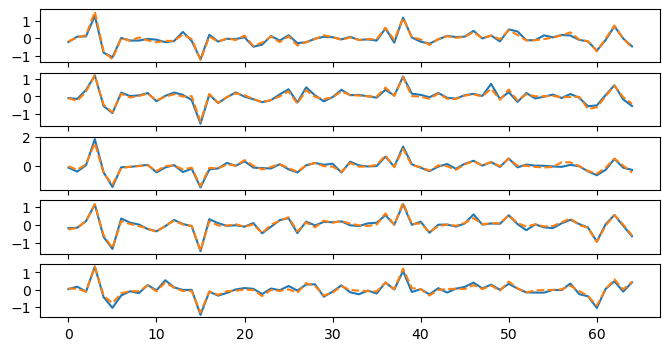

In [5]:
row, col = 5 , 1

fig = plt.figure(figsize=(8,4))

gs = gridspec.GridSpec(row, col, figure=fig)

for i in range(row):
    rand_index = np.random.randint(0, r.shape[0])
    ax = fig.add_subplot(gs[i, 0])

    ax.plot(x[rand_index], )
    ax.plot(r[rand_index], linestyle="--")



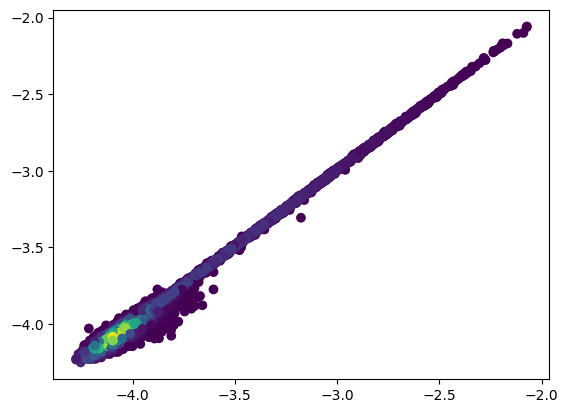

In [16]:
fig, ax = plt.subplots(1,1)

y_true = x[:,-1]
y_pred = r[:,-1]

y_true = y_true*test_data.std + test_data.mean
y_pred = y_pred*test_data.std + test_data.mean

xy = np.vstack([y_true,y_pred])
z = gaussian_kde(xy)(xy)

ax.scatter(y_true, y_pred, c= z)


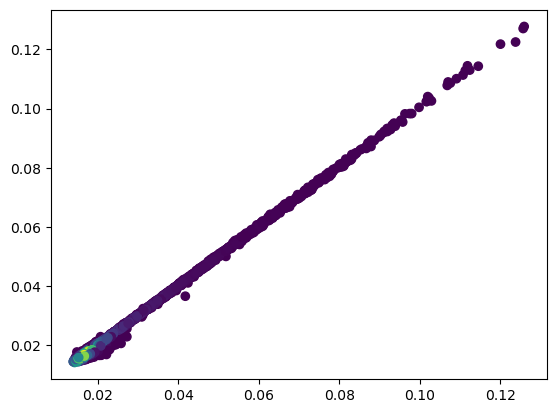

In [17]:
fig, ax = plt.subplots(1,1)

y_true = x[:,-1]
y_pred = r[:,-1]

y_true = y_true*test_data.std + test_data.mean
y_pred = y_pred*test_data.std + test_data.mean

y_true = np.exp(y_true)
y_pred = np.exp(y_pred)

xy = np.vstack([y_true,y_pred])
z = gaussian_kde(xy)(xy)

ax.scatter(y_true, y_pred, c= z)

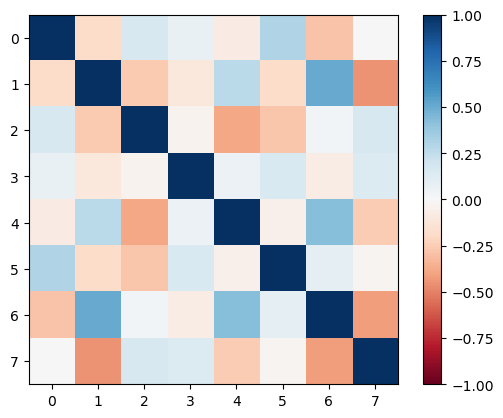

In [22]:
corr_mat = np.corrcoef(mu.T)
plt.imshow(corr_mat, vmin = -1, vmax=1, cmap="RdBu")
plt.colorbar()